In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro,normaltest,mannwhitneyu,f_oneway

In [2]:
exams = pd.read_csv(r'..\data\raw\exams.csv')

In [3]:
df = exams.copy()

In [4]:
df.shape

(1000, 8)

In [5]:
df.columns

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'],
      dtype='object')

In [6]:
df.describe()

,math score,reading score,writing score
count,1000.000000,1000.000000,1000.000000
mean,67.810000,70.382000,69.140000
std,15.250196,14.107413,15.025917
min,15.000000,25.000000,15.000000
25%,58.000000,61.000000,59.000000
50%,68.000000,70.500000,70.000000
75%,79.250000,80.000000,80.000000
max,100.000000,100.000000,100.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [8]:
df.sample(5)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
821,male,group E,some high school,free/reduced,none,66,60,59
511,male,group C,associate's degree,free/reduced,none,72,80,75
769,male,group C,some high school,standard,completed,60,51,55
753,female,group B,some high school,free/reduced,completed,37,48,46
409,female,group C,high school,standard,none,69,81,70


In [9]:
df.isna().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

In [10]:
for col in df.columns:
    print(f'==========={col}===========')
    print(f'Numero de unicos: {df[col].nunique()}')
    print(f'Valores Unicos: {df[col].unique()}')
    print('\n')

===========gender===========
Numero de unicos: 2
Valores Unicos: ['female' 'male']


===========race/ethnicity===========
Numero de unicos: 5
Valores Unicos: ['group D' 'group B' 'group C' 'group E' 'group A']


===========parental level of education===========
Numero de unicos: 6
Valores Unicos: ['some college' "associate's degree" 'some high school'
 "bachelor's degree" "master's degree" 'high school']


===========lunch===========
Numero de unicos: 2
Valores Unicos: ['standard' 'free/reduced']


===========test preparation course===========
Numero de unicos: 2
Valores Unicos: ['completed' 'none']


===========math score===========
Numero de unicos: 79
Valores Unicos: [ 59  96  57  70  83  68  82  46  80  74  53  76  55  56  35  87  65  66
  67  89  99  58  90  69  32  86  52  63  62  79  71  61  75  73  64  23
  41  84  85  88  91  51 100  48  98  72  43  50  38  81  47  49  44  60
  93  77  20  78  94  39  42  54  37  45  27  92  95  34  97  31  40  33
  21  25  28  15  24  30  36]

In [11]:
df.drop(columns='race/ethnicity',inplace=True) # Variable que para este analisis, no nos parece reelevante.

In [12]:
def outliers(df, col, mode='detect'):
    """
    Detecta o elimina outliers usando el método IQR.

    Parámetros:
        df : DataFrame
        col : str - nombre de la columna numérica
        mode : str - 'detect' para obtener los outliers, 'remove' para eliminarlos

    Retorna:
        DataFrame con los outliers detectados o con los outliers eliminados
    """
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    if mode == 'detect':
        return df[(df[col] < lower) | (df[col] > upper)]
    elif mode == 'remove':
        return df[(df[col] >= lower) & (df[col] <= upper)]
    else:
        raise ValueError("El parámetro 'mode' debe ser 'detect' o 'remove'")

In [13]:
num_vars = df.select_dtypes('int').columns

for var in num_vars:
    outl = outliers(df,var,'detect')
    print(f'Outliers en {var}: {len(outl)}')

Outliers en math score: 6
Outliers en reading score: 5
Outliers en writing score: 5


In [ ]:
for num in num_vars:
    df = outliers(df,num,'remove')
df = outliers(df,'math score','remove')

#### Debido a la baja cantidad de outliers, los eliminamos directamente.

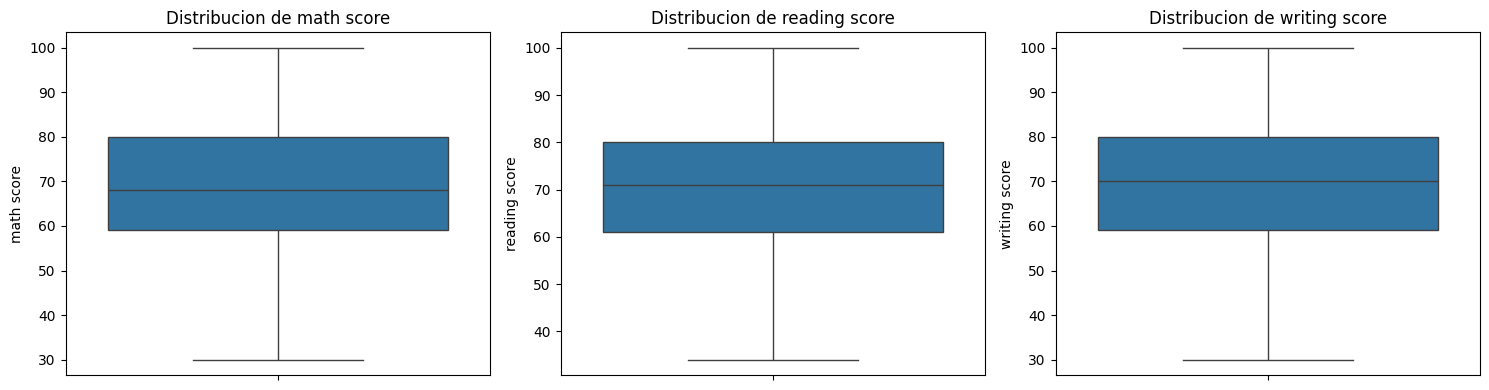

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

for ax, col in zip(axes, num_vars):
    sns.boxplot(df[col], ax=ax)
    ax.set_title(f'Distribucion de {col}')

plt.tight_layout()
plt.show()

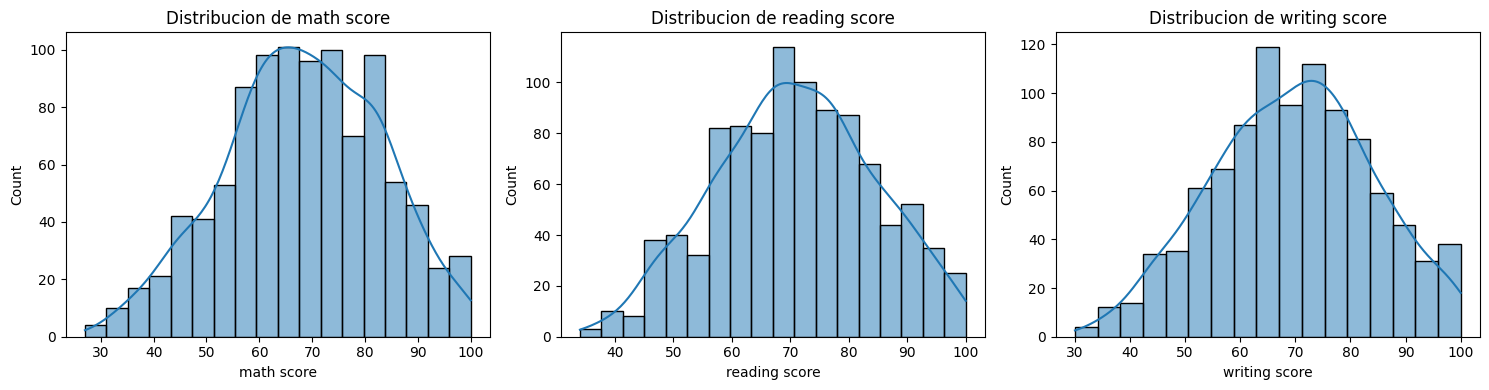

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

for ax, col in zip(axes, num_vars):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f'Distribucion de {col}')

plt.tight_layout()
plt.show()

In [17]:
for col in num_vars:
    print(f"\n Variable: {col}")
    
    for test_name, test_func in [('Shapiro-Wilk', shapiro), ('D’Agostino-Pearson', normaltest)]:
        stat, p = test_func(df[col])
        conclusion = "Es normal" if p > 0.05 else "No es normal"
        print(f"{test_name}: Estadístico = {stat:.4f}, p = {p:.4f} → {conclusion}")



 Variable: math score
Shapiro-Wilk: Estadístico = 0.9931, p = 0.0001 → No es normal
D’Agostino-Pearson: Estadístico = 15.3628, p = 0.0005 → No es normal

 Variable: reading score
Shapiro-Wilk: Estadístico = 0.9928, p = 0.0001 → No es normal
D’Agostino-Pearson: Estadístico = 19.5494, p = 0.0001 → No es normal

 Variable: writing score
Shapiro-Wilk: Estadístico = 0.9929, p = 0.0001 → No es normal
D’Agostino-Pearson: Estadístico = 18.6850, p = 0.0001 → No es normal


### Aunque visualmente parecían normales, los tests estadísticos (Shapiro-Wilk y D’Agostino-Pearson) rechazan la hipótesis de normalidad en los tres casos.

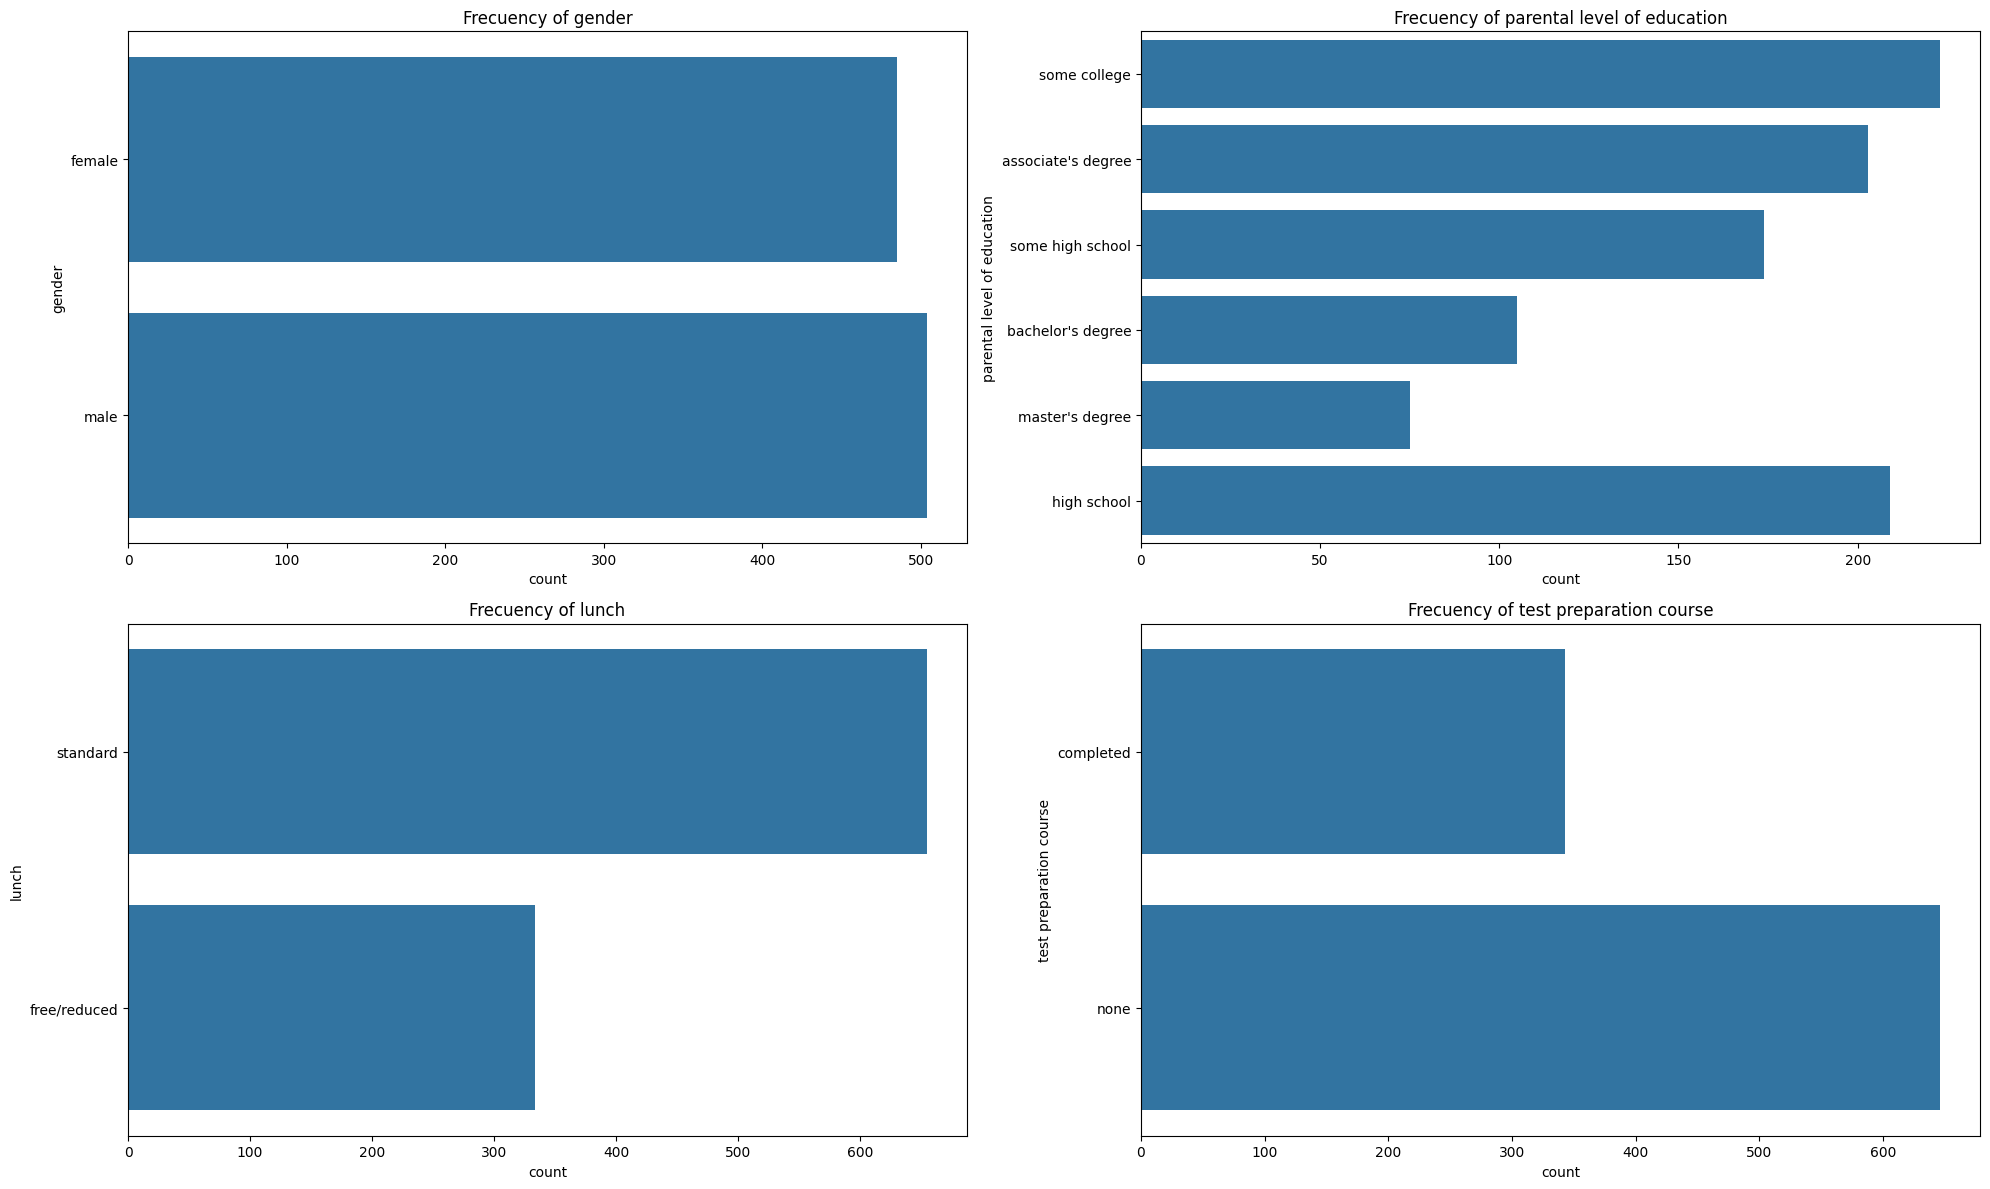

In [31]:
col_obj = df.select_dtypes('object').columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5 * len(col_obj), 12))
axes = axes.flatten()

for ax, col in zip(axes, col_obj):
    sns.countplot(df[col], ax=ax)
    ax.set_title(f'Frecuency of {col}')

# Ajusta el diseño
plt.tight_layout()
plt.show()

1. Género (gender)
La distribución está bastante equilibrada entre hombres y mujeres, con ligera mayoría de hombres. Esto significa que no habrá sesgo importante de género en el análisis de rendimiento.

2. Nivel educativo de los padres (parental level of education)
La mayoría tiene “some college” o “high school”, lo que sugiere un nivel educativo medio predominante. Pocos estudiantes tienen padres con máster, lo cual puede ser relevante si encuentras que el rendimiento mejora con mayor nivel educativo.

3. Tipo de almuerzo (lunch)
La mayoría accede a almuerzo estándar, pero hay una proporción importante (casi 1 de cada 3) con almuerzo reducido/gratuito.

4. Curso de preparación (test preparation course)
Más estudiantes no han completado el curso de preparación que los que sí lo han hecho. Es interesante para análisis bivariantes: ¿tienen mejores notas los que hicieron el curso?

In [ ]:
for col in num_vars:
    grupo1 = df[df['test preparation course'] == 'completed'][col]
    grupo2 = df[df['test preparation course'] == 'none'][col]

    stat, p = mannwhitneyu(grupo1, grupo2, alternative='two-sided')
    print(f'Mann-Whitney U Test para {col} → Estadístico: {stat:.4f}, p = {p:.4f}')

    if p < 0.05:
        print(f"En {col} hay diferencia significativa entre los grupos")
    else:
        print(f"En {col} no hay diferencia significativa")
    print("\n")

# ¿Porque utilizo Mann-Whitneyu? las variables no son normales..

Mann-Whitney U Test para math score → Estadístico: 124487.0000, p = 0.0018
En math score hay diferencia significativa entre los grupos


Mann-Whitney U Test para reading score → Estadístico: 138755.5000, p = 0.0000
En reading score hay diferencia significativa entre los grupos


Mann-Whitney U Test para writing score → Estadístico: 151715.0000, p = 0.0000
En writing score hay diferencia significativa entre los grupos




### Los estudiantes que completaron el curso de preparación obtienen notas significativamente distintas (más altas o más bajas) en las 3 materias que los que no lo hicieron. Como el valor p = 0.0005 (< 0.05), la diferencia es estadísticamente significativa.

In [20]:
print(df.groupby('test preparation course')[['math score', 'reading score', 'writing score']].mean())

                         math score  reading score  writing score
test preparation course                                          
completed                 70.334302      74.726744      75.808140
none                      67.130031      68.645511      66.212074


### Vemos que los que han completado el curso tiene 4 puntos mas de media en matematicas, 6 puntos mas de media en reading y 10 mas en writing.

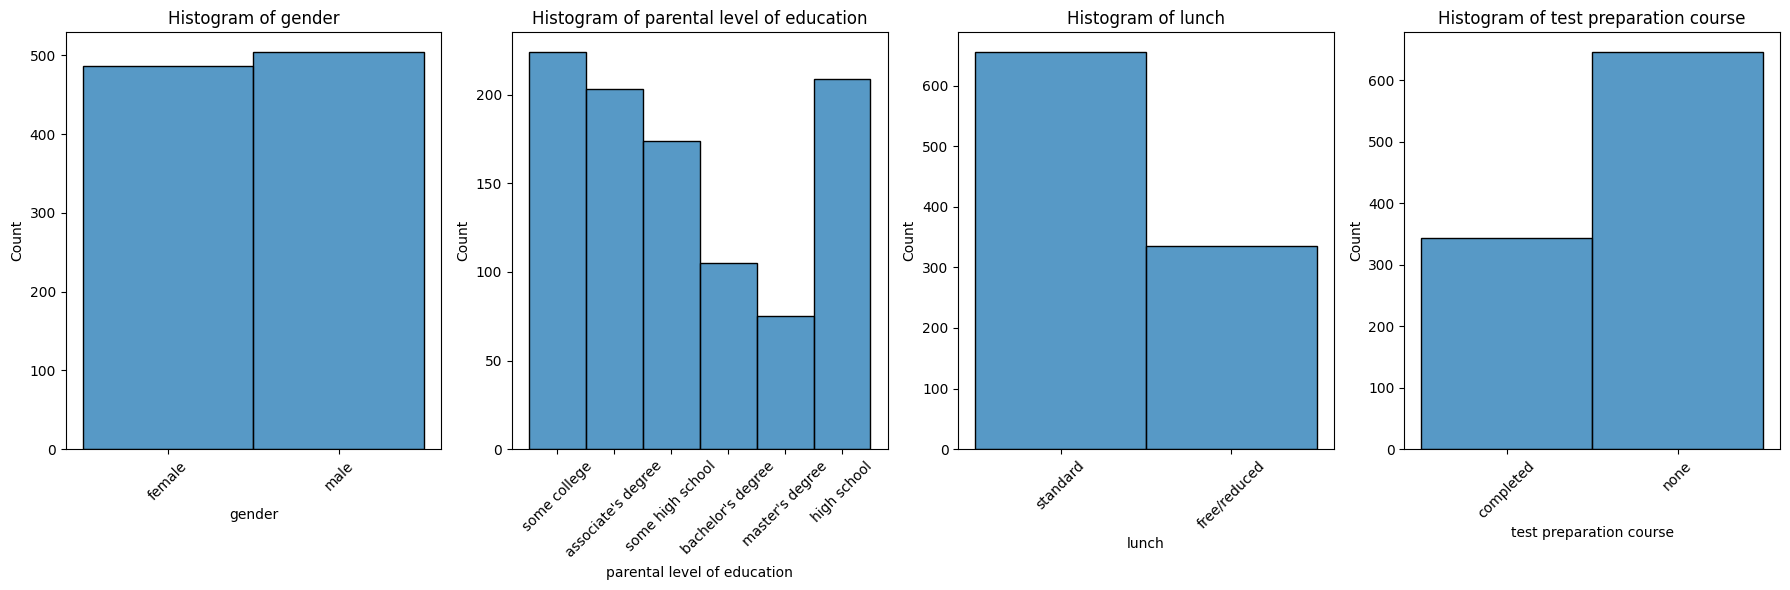

In [21]:
fig, axes = plt.subplots(1, 4, figsize=(18, 6))
for i, col in enumerate(col_obj):
    sns.histplot(x=col, data=df, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

- Gender: La distribución está equilibrada entre hombres y mujeres, con una ligera mayoría masculina. Esto indica que no hay un sesgo en el género.

- Parental level of education: Se observa una amplia variedad de niveles educativos, siendo los más comunes some college, high school y associate's degree. Esto podría influir en las expectativas académicas del estudiante (lo veremos mas adelante).

- Lunch: La mayoría de los estudiantes reciben almuerzo estándar, aunque hay una proporción notable con almuerzo gratuito o reducido.

- Test preparation course: Más estudiantes no han completado el curso de preparación. Esta variable será clave para analizar diferencias en el rendimiento académico.

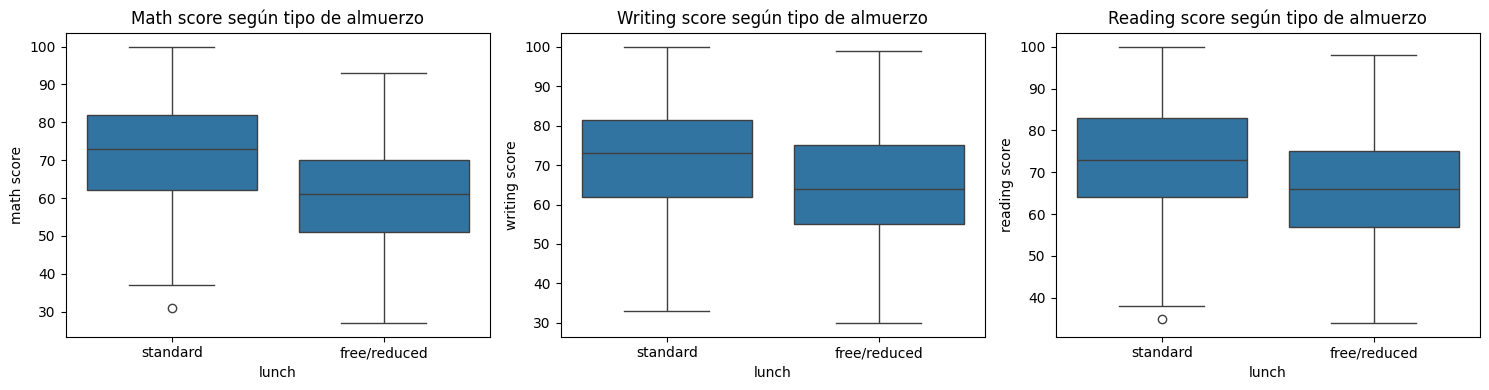

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

variables = ['math score', 'writing score', 'reading score']
titulos = ['Math score según tipo de almuerzo', 
           'Writing score según tipo de almuerzo', 
           'Reading score según tipo de almuerzo']

for ax, var, titulo in zip(axes, variables, titulos):
    sns.boxplot(x='lunch', y=var, data=df, ax=ax)
    ax.set_title(titulo)
plt.tight_layout()
plt.show()

### Los estudiantes que reciben almuerzo estándar tienden a obtener notas más altas en math, writing y reading que aquellos con almuerzo gratuito/reducido.

In [23]:
print(df.groupby('parental level of education')[['math score', 'writing score', 'reading score']].mean())

                             math score  writing score  reading score
parental level of education                                          
associate's degree            70.556650      72.256158      72.847291
bachelor's degree             69.866667      72.266667      71.819048
high school                   66.564593      67.861244      70.224880
master's degree               71.026667      71.746667      71.973333
some college                  68.642857      69.473214      70.941964
some high school              64.867816      65.913793      67.563218


In [24]:
for col in variables:
    grupo = [df[df['parental level of education'] == nivel][col] for nivel in df['parental level of education'].unique()]
    stat, p = f_oneway(*grupo)

    print(f'ANOVA → Estadístico {col}: {stat:.4f}, p = {p:.4f}')


ANOVA → Estadístico math score: 4.2877, p = 0.0007
ANOVA → Estadístico writing score: 5.3556, p = 0.0001
ANOVA → Estadístico reading score: 3.2092, p = 0.0070


### Hay diferencias estadísticamente significativas en las notas de math, writing y reading según el nivel educativo de los padres (p < 0.05 en los tres casos). Esto significa que el nivel de estudios de los padres tiene un impacto real en el rendimiento académico de los estudiantes.

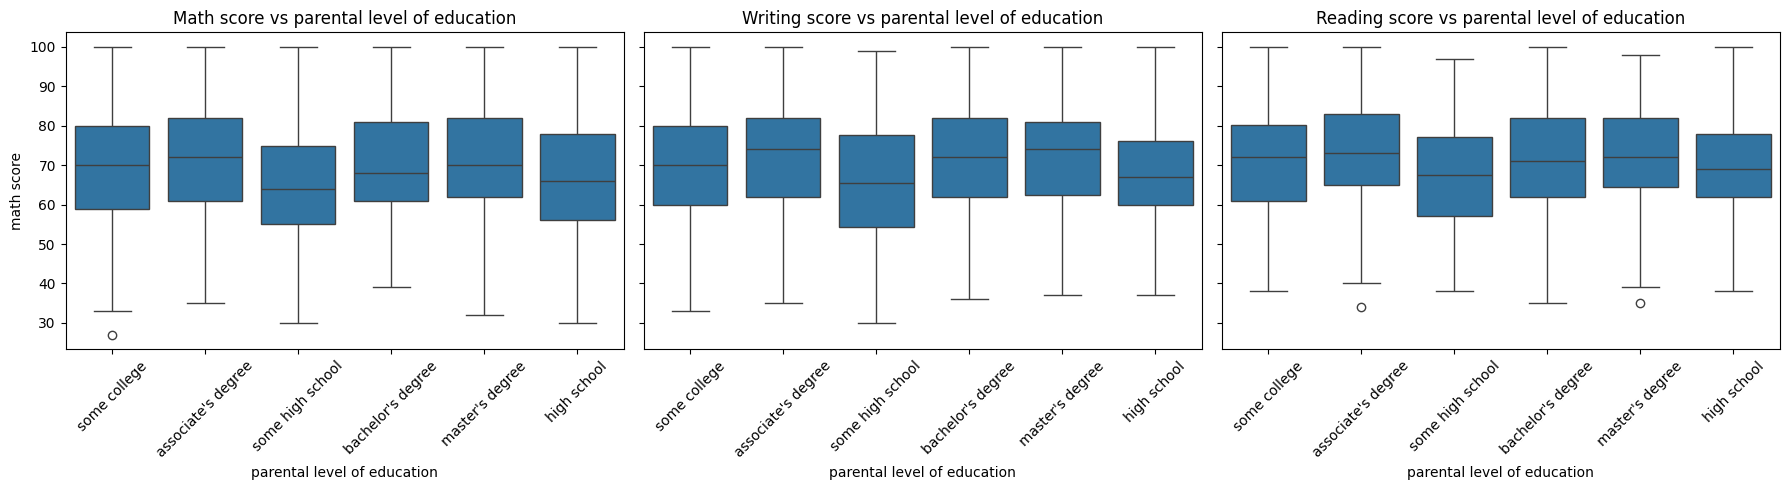

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

variables = ['math score', 'writing score', 'reading score']
titulos = ['Math score vs parental level of education', 
           'Writing score vs parental level of education', 
           'Reading score vs parental level of education']

for ax, var, titulo in zip(axes, variables, titulos):
    sns.boxplot(x='parental level of education', y=var, data=df, ax=ax)
    ax.set_title(titulo)
    axes[0].tick_params(axis='x', rotation=45)
    axes[1].tick_params(axis='x', rotation=45)
    axes[2].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

#### Conclusiones e Insights

Tras analizar el rendimiento académico de los estudiantes en matemáticas, lectura y escritura, observamos que existen diferencias relevantes asociadas a variables socioeducativas.

- En general, la distribución de las notas muestra cierta asimetría hacia las puntuaciones bajas, especialmente en matemáticas. Se identificaron valores atípicos que fueron eliminados para asegurar la validez estadística del análisis.

- Los estudiantes que completaron el curso de preparación obtuvieron, en promedio, mejores resultados en matemáticas. Esta diferencia fue estadísticamente significativa según el test de Mann-Whitney, lo que sugiere un impacto positivo de este tipo de intervención formativa.

- También se evidencian brechas de rendimiento asociadas al tipo de almuerzo: los alumnos con almuerzo estándar (posible indicador de un nivel socioeconómico más favorable) muestran puntuaciones más altas en las tres materias, en comparación con quienes reciben almuerzo gratuito o reducido.

- El nivel educativo de los padres aparece como un factor importante. Los resultados del test ANOVA indican diferencias significativas en las notas medias de los estudiantes según el nivel de estudios alcanzado por sus padres, lo que refuerza la idea de que el entorno familiar influye en el rendimiento académico.

Dado que los datos no siguen una distribución normal, se utilizaron pruebas no paramétricas como Mann-Whitney y ANOVA para garantizar la robustez de los resultados. 


In [26]:
df.to_csv('../data/processed/exams_clean.csv')